### **Inrtoduction to Data Science course, fall 2021. Final Project.**
# **Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines**
### **Team: Polina Gridneva, Anna Kurbatova, Pavel Krasnik**


Problem statement: https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/

In [1]:
from google.colab import files
uploaded = files.upload()

Saving submission_format.csv to submission_format.csv
Saving test_set_features.csv to test_set_features.csv
Saving training_set_features.csv to training_set_features.csv
Saving training_set_labels.csv to training_set_labels.csv


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import copy
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from time import time
import lightgbm as lgb
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [62]:
train = pd.read_csv('training_set_features.csv', index_col="respondent_id")
train_labels = pd.read_csv('training_set_labels.csv', index_col="respondent_id")


test = pd.read_csv('test_set_features.csv', index_col="respondent_id")
submission = pd.read_csv('submission_format.csv')

In [63]:
train.shape, train_labels.shape, test.shape

((26707, 35), (26707, 2), (26708, 35))

In [64]:
columns = train.columns

## Exploratory data analysis

In [50]:
labels = pd.read_csv('training_set_labels.csv')
trainset = pd.read_csv('training_set_features.csv')
testset = pd.read_csv('test_set_features.csv')
del labels['respondent_id']
trainset = pd.concat([trainset, labels], axis=1)

testset['h1n1_vaccine'] = -1
testset['seasonal_vaccine'] = -1
dataset = trainset.append(testset, ignore_index=True, sort=False)

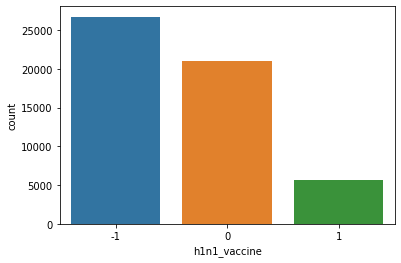

In [51]:
sns.countplot(x='h1n1_vaccine', data=dataset);

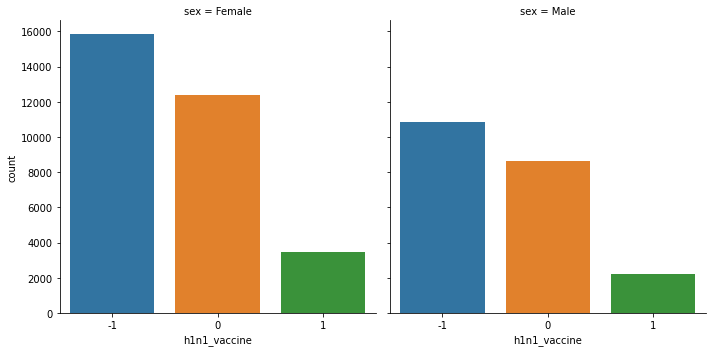

In [52]:
sns.catplot(x='h1n1_vaccine', col='sex', kind='count', data=dataset);

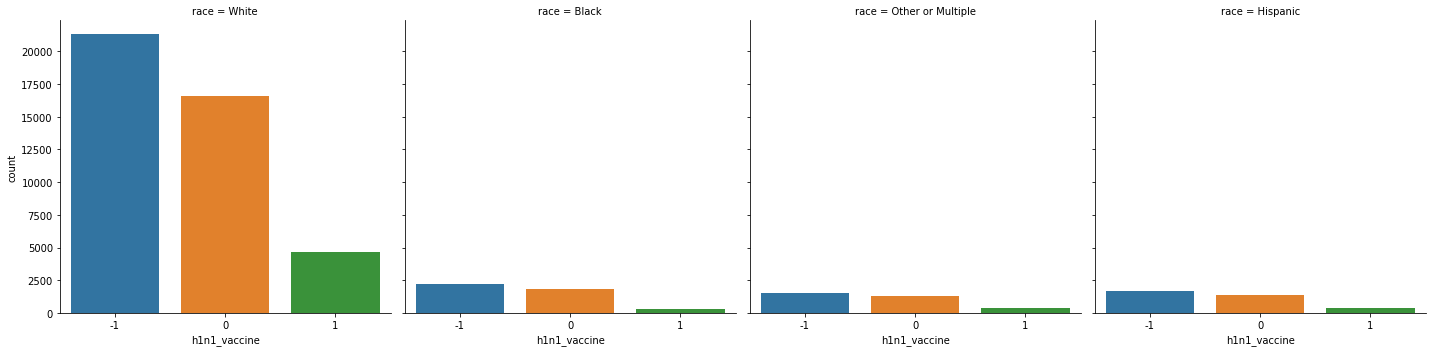

In [53]:
sns.catplot(x='h1n1_vaccine', col='race', kind='count', data=dataset);

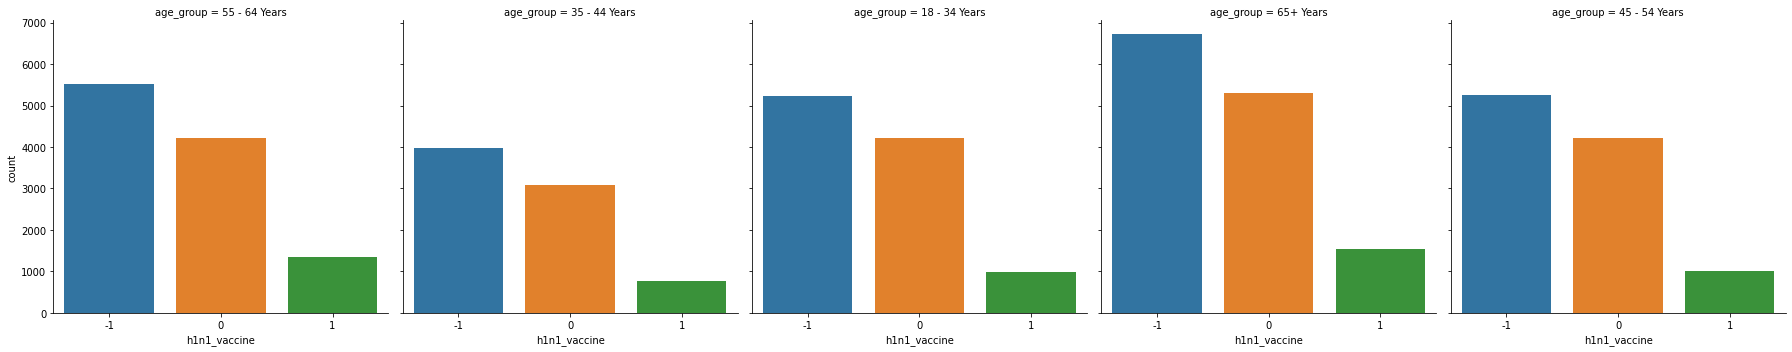

In [54]:
sns.catplot(x='h1n1_vaccine', col='age_group', kind='count', data=dataset);

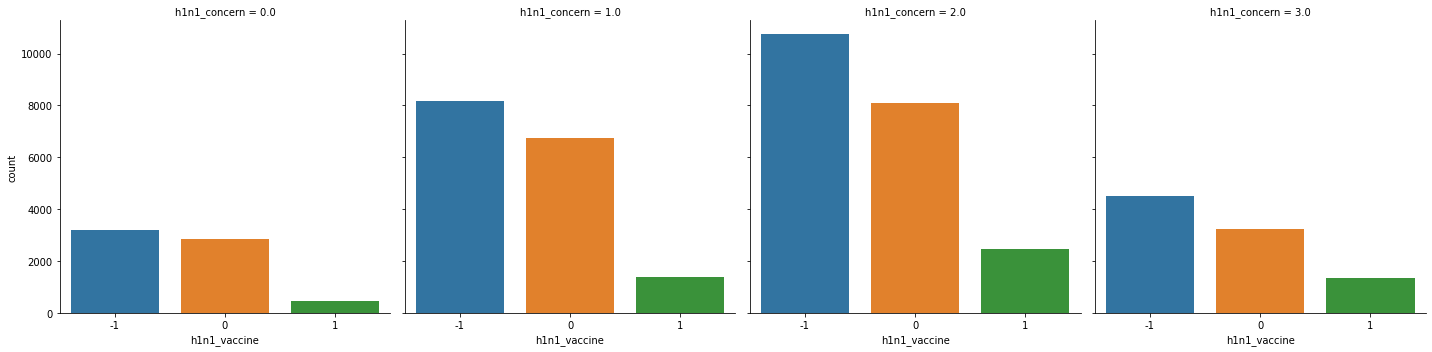

In [55]:
sns.catplot(x='h1n1_vaccine', col='h1n1_concern', kind='count', data=dataset);

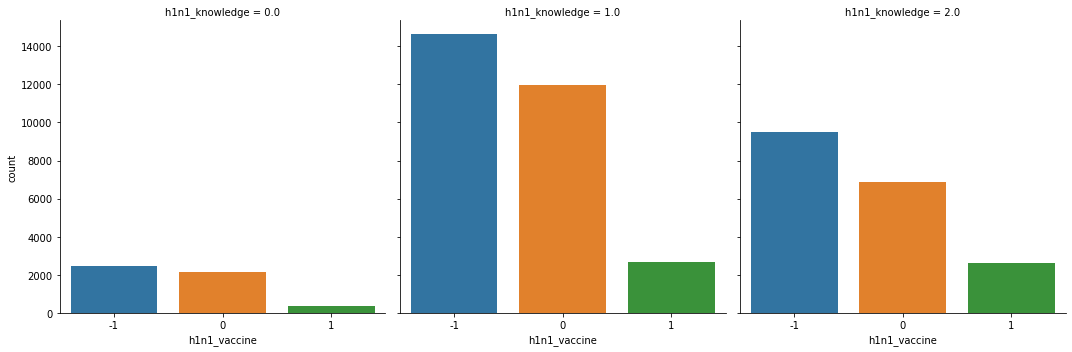

In [16]:
sns.catplot(x='h1n1_vaccine', col='h1n1_knowledge', kind='count', data=dataset);

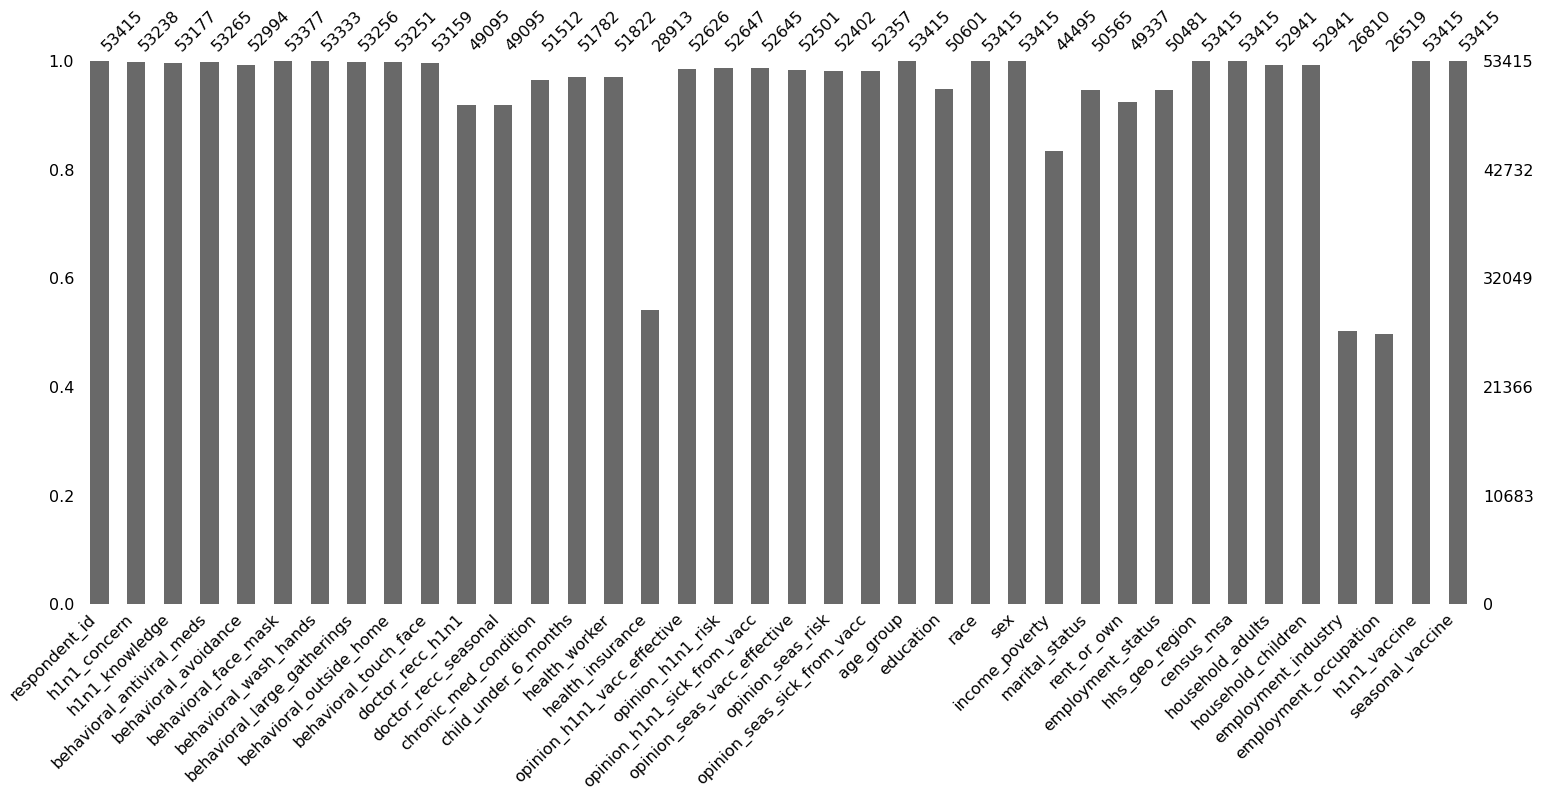

In [18]:
import missingno as msno
msno.bar(dataset);

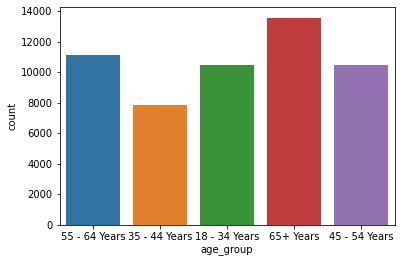

In [19]:
sns.countplot(x='age_group', data=dataset);

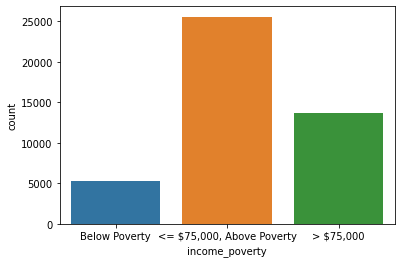

In [20]:
sns.countplot(x='income_poverty', data=dataset);

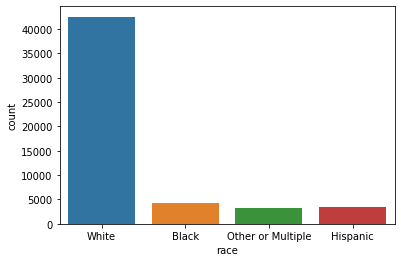

In [21]:
sns.countplot(x='race', data=dataset);

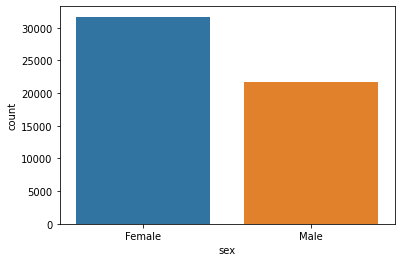

In [22]:
sns.countplot(x='sex', data=dataset);

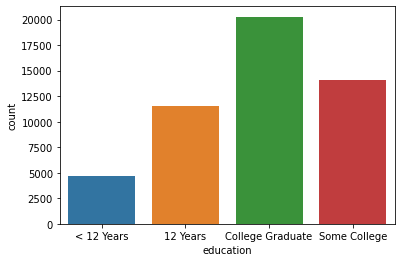

In [23]:
sns.countplot(x='education', data=dataset);

In [24]:
trainset.groupby(['race']).h1n1_vaccine.value_counts(normalize=True)

race               h1n1_vaccine
Black              0               0.851275
                   1               0.148725
Hispanic           0               0.792023
                   1               0.207977
Other or Multiple  0               0.783499
                   1               0.216501
White              0               0.781123
                   1               0.218877
Name: h1n1_vaccine, dtype: float64

In [25]:
trainset.groupby(['sex']).h1n1_vaccine.value_counts(normalize=True)

sex     h1n1_vaccine
Female  0               0.780552
        1               0.219448
Male    0               0.797769
        1               0.202231
Name: h1n1_vaccine, dtype: float64

In [26]:
trainset.groupby(['age_group']).h1n1_vaccine.value_counts(normalize=True)

age_group      h1n1_vaccine
18 - 34 Years  0               0.809971
               1               0.190029
35 - 44 Years  0               0.802235
               1               0.197765
45 - 54 Years  0               0.805269
               1               0.194731
55 - 64 Years  0               0.757145
               1               0.242855
65+ Years      0               0.773345
               1               0.226655
Name: h1n1_vaccine, dtype: float64

In [27]:
trainset.groupby(['education']).h1n1_vaccine.value_counts(normalize=True)

education         h1n1_vaccine
12 Years          0               0.815249
                  1               0.184751
< 12 Years        0               0.832840
                  1               0.167160
College Graduate  0               0.754085
                  1               0.245915
Some College      0               0.792134
                  1               0.207866
Name: h1n1_vaccine, dtype: float64

In [28]:
trainset.groupby(['income_poverty']).h1n1_vaccine.value_counts(normalize=True)

income_poverty             h1n1_vaccine
<= $75,000, Above Poverty  0               0.796588
                           1               0.203412
> $75,000                  0               0.746990
                           1               0.253010
Below Poverty              0               0.808676
                           1               0.191324
Name: h1n1_vaccine, dtype: float64

In [29]:
trainset.groupby(['h1n1_knowledge']).h1n1_vaccine.value_counts(normalize=True)

h1n1_knowledge  h1n1_vaccine
0.0             0               0.855946
                1               0.144054
1.0             0               0.818263
                1               0.181737
2.0             0               0.721935
                1               0.278065
Name: h1n1_vaccine, dtype: float64

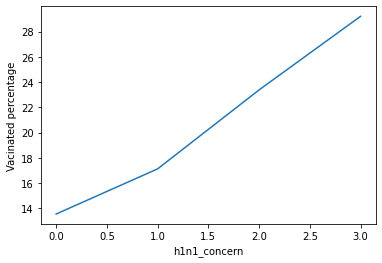

In [30]:
k = trainset.groupby(['h1n1_concern']).h1n1_vaccine.value_counts(normalize=True).unstack().iloc[:, 1]*100
k.plot(ylabel='Vacinated percentage');

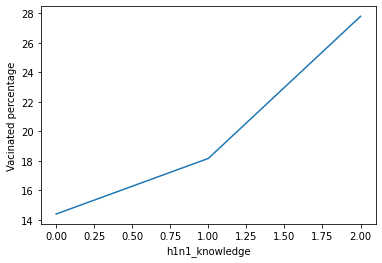

In [31]:
k = trainset.groupby(['h1n1_knowledge']).h1n1_vaccine.value_counts(normalize=True).unstack().iloc[:, 1]*100
k.plot(ylabel='Vacinated percentage');

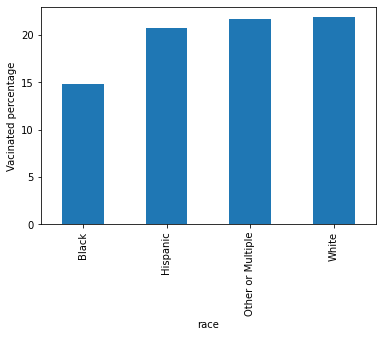

In [32]:
k = trainset.groupby(['race']).h1n1_vaccine.value_counts(normalize=True).unstack().iloc[:, 1]*100
k.plot(kind='bar', ylabel='Vacinated percentage')

## Encode string to int

In [72]:
columns = columns.drop(['health_insurance', 'employment_industry', 'employment_occupation'])

In [66]:
from tqdm.notebook import tqdm

for col in tqdm(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

  0%|          | 0/35 [00:00<?, ?it/s]

In [67]:
train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                        int64
education                        int64
race                             int64
sex                              int64
income_poverty           

In [68]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

In [73]:
# From numpy to pandas.DataFrame (convinient)

train = pd.DataFrame(train, columns=columns)
test = pd.DataFrame(test, columns=columns)

In [74]:
train.shape, test.shape

((26707, 32), (26708, 32))

In [75]:
# columns_fitting = [
#       'hhs_geo_region',
#       'employment_industry',
#       'employment_occupation',
#       'age_group',
#       'opinion_seas_sick_from_vacc',
#       'opinion_seas_risk',
#       'opinion_h1n1_sick_from_vacc',
#       'h1n1_concern',
#       'education',
#       'opinion_h1n1_risk',
#       'income_poverty',
#       'opinion_seas_vacc_effective',
#       'census_msa',
#       'opinion_h1n1_vacc_effective',
#       'race',
#       'h1n1_knowledge',
#       'household_adults',
#       'household_children',
#       'sex'
# ]

def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                
    return train_df, test_df


train, test = uid_aggregation(train, test,  ['opinion_seas_sick_from_vacc'],
                              ['hhs_geo_region'],
                                  ['mean', 'std', 'median'])

In [76]:
params = {'num_leaves': 100,
          'min_child_weight': 0.01,
          'feature_fraction': 0.5,
          'bagging_fraction': 0.3,
          'min_data_in_leaf': 33,
          'objective': 'binary',
          'max_depth': 7,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'random_state': 47,
         }

In [77]:
h1n1 = train_labels.h1n1_vaccine
seasonal = train_labels.seasonal_vaccine

train.shape, test.shape, h1n1.shape, seasonal.shape

((26707, 35), (26708, 35), (26707,), (26707,))

In [78]:
X_train = train
X_test = test
y_train = h1n1

In [79]:
X_train.shape, X_test.shape, y_train.shape

((26707, 35), (26708, 35), (26707,))

In [80]:
from sklearn.model_selection import StratifiedKFold

preds_h1n1 = np.zeros((len(X_test))) 
oof = np.zeros((len(X_train)))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    
    preds_h1n1 += clf.predict(X_test) / folds.n_splits
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.926248	valid_1's auc: 0.845341
Early stopping, best iteration is:
[336]	training's auc: 0.906679	valid_1's auc: 0.846878
Fold 1 finished in 0:00:06.592906
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.929129	valid_1's auc: 0.834293
Early stopping, best iteration is:
[263]	training's auc: 0.898119	valid_1's auc: 0.835288
Fold 2 finished in 0:00:05.877920
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.929649	valid_1's auc: 0.831109
Early stopping, best iteration is:
[276]	training's auc: 0.901448	valid_1's auc: 0.833947
Fold 3 finished in 0:00:05.994394
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.928404	valid_1's auc: 0.832575
Early stopping, best iteration is:
[244]	training's auc: 0.895651	valid_1's auc:

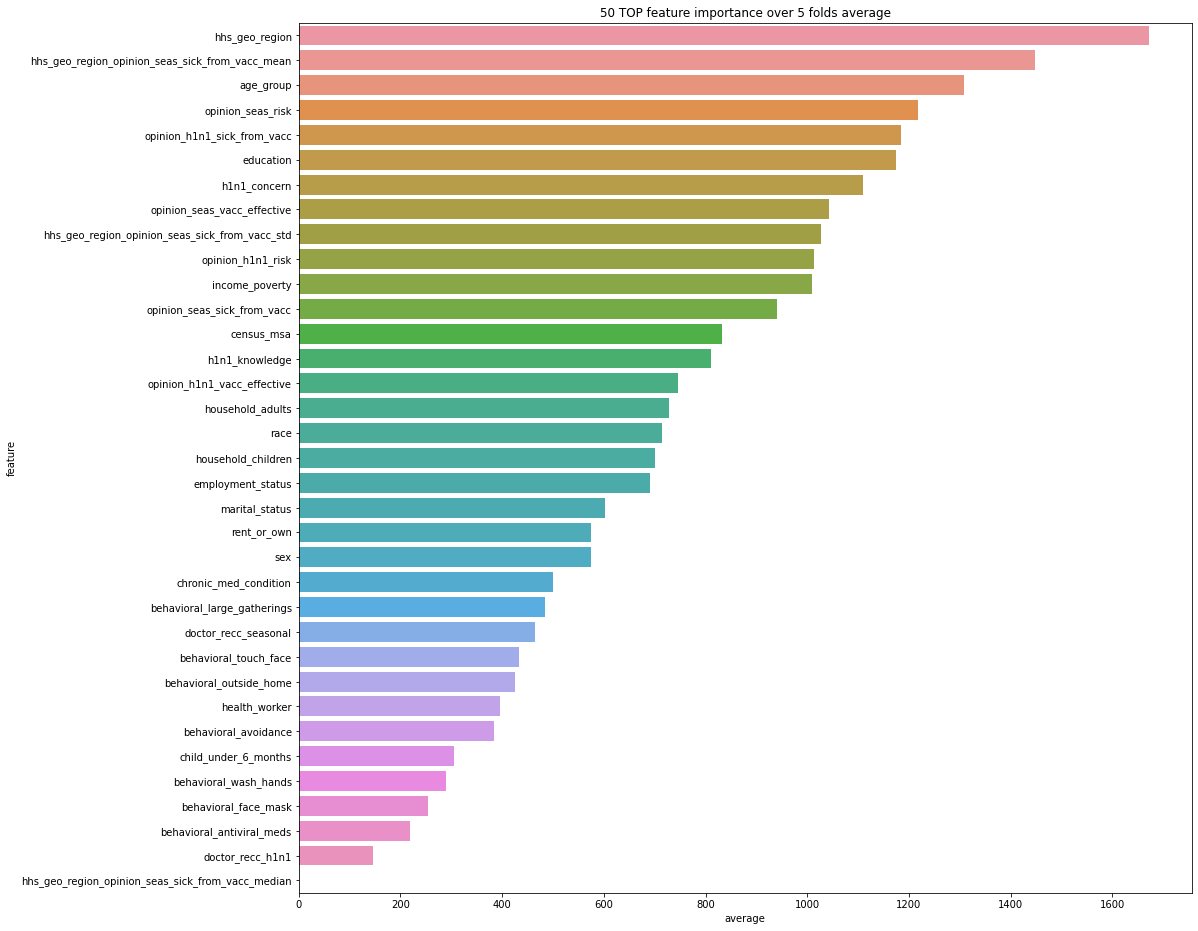

In [81]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [82]:
from sklearn.model_selection import StratifiedKFold

y_train_seasonal = seasonal

preds_seasonal = np.zeros((len(X_test))) 
oof = np.zeros((len(X_train)))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train_seasonal)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    
    preds_seasonal += clf.predict(X_test) / folds.n_splits

    # oof[test_idx] = clf.predict(X_train.iloc[test_idx])
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.928523	valid_1's auc: 0.841182
Early stopping, best iteration is:
[227]	training's auc: 0.891624	valid_1's auc: 0.843058
Fold 1 finished in 0:00:05.658388
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.928569	valid_1's auc: 0.835382
Early stopping, best iteration is:
[301]	training's auc: 0.903863	valid_1's auc: 0.836876
Fold 2 finished in 0:00:06.229872
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.929347	valid_1's auc: 0.834391
Early stopping, best iteration is:
[250]	training's auc: 0.896624	valid_1's auc: 0.836529
Fold 3 finished in 0:00:05.746884
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.929514	valid_1's auc: 0.833996
Early stopping, best iteration is:
[232]	training's auc: 0.893485	valid_1's auc:

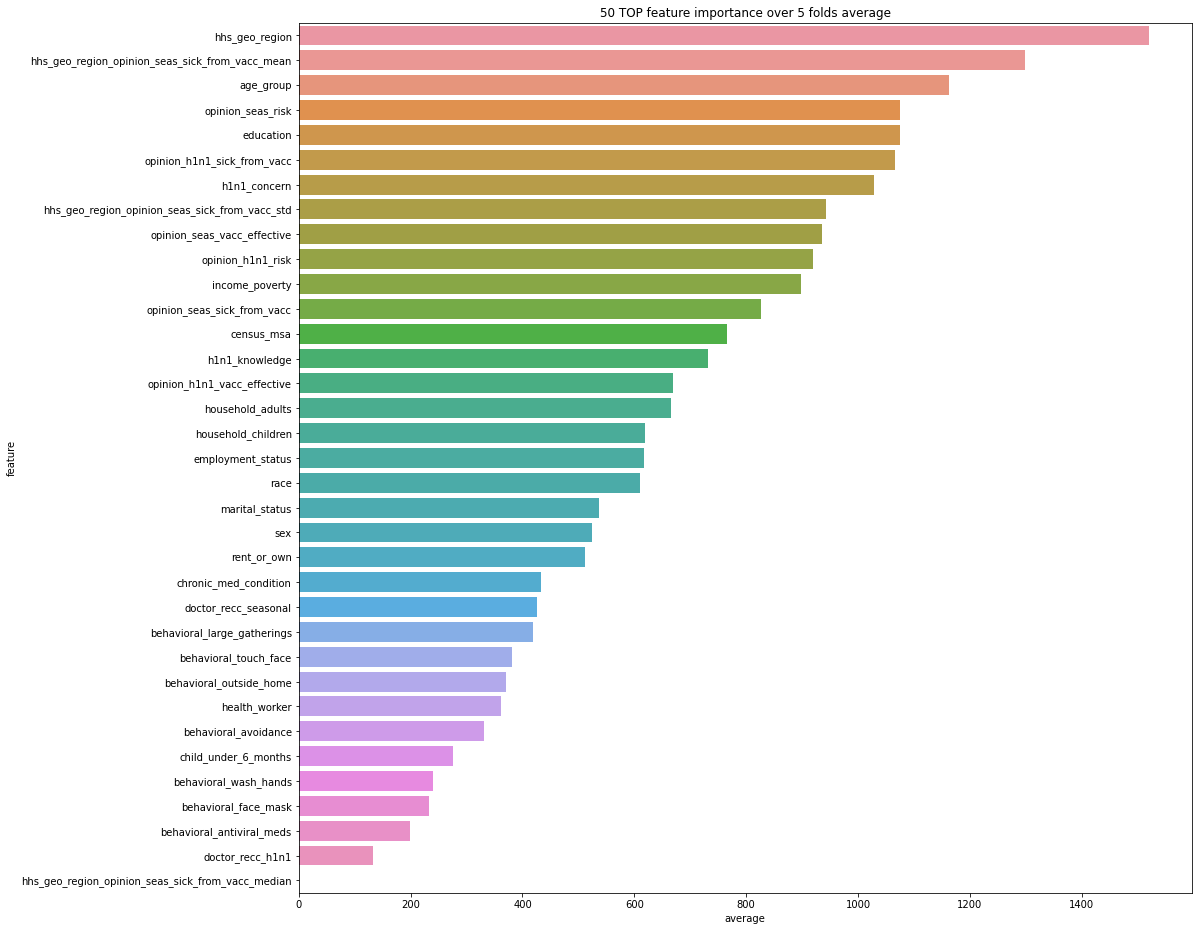

In [83]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [84]:
submit_columns = ['h1n1_vaccine', 'seasonal_vaccine']

your_submit = pd.DataFrame(np.hstack((preds_h1n1[:, None], preds_seasonal[:, None])), columns=submit_columns).reset_index().rename(columns={'index': 'respondent_id'})
your_submit['respondent_id'] += 26707
your_submit.to_csv('sec_submit.csv', index=False)